# **APLICAÇÃO DAS REDES FULLY CONNECTED PARA CLASSIFICAÇÃO MULTICLASSE**

Nesse material, estarei focado em mostrar como construir uma rede que pode receber uma imagem de um dígito manuscrito como entrada e identificar qual dos dez dígitos (0 a 9) a imagem representa e apresentar essa informação em suas saídas.

## **DATASET A SER UTILIZADO**

O dataset que será utilizado nesse exemplo é o **MNIST** (*Modified National Institute of Standards and Technology*), que contém imagens de digitos manuscritos.

**SOBRE O DATASET**

O *MNIST* contém 70.000 imagens, cada uma com sua *label* indicando o dígito que ela representa, em tons de cinza de dígitos manuscritos (de 0 a 9), divididas em 60.000 exemplos de treinamento e 10.000 exemplos de teste (que pode ser alterado). Cada imagem tem 28 pixels de altura e 28 pixels de largura, totalizando 784 (28x28) pixels. As imagens já estão em apenas um canal, ou seja, cada pixel tem um único valor de pixel associado a ele, indicando a claridade ou escuridão desse pixel, com números mais altos significando mais escuro. Este valor de pixel é um número inteiro entre 0 e 255.

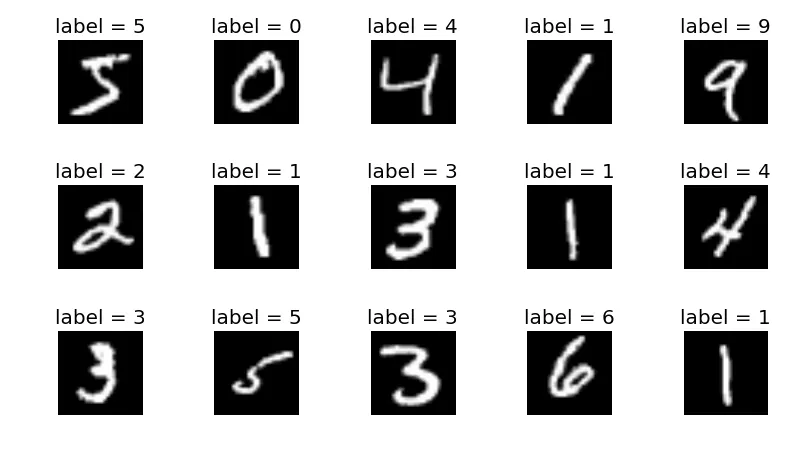 *Exemplo das imagens e dos rótulos que estão presentes no dataset.*

### **EXPLORANDO O DATASET**

In [8]:
import idx2numpy

TRAIN_IMAGE_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\train-images-idx3-ubyte\train-images-idx3-ubyte'
TRAIN_LABEL_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\train-labels-idx1-ubyte\train-labels-idx1-ubyte'
TEST_IMAGE_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\t10k-images-idx3-ubyte\t10k-images-idx3-ubyte'
TEST_LABEL_FILENAME = r'C:\Users\João Pedro\Documents\LDL\data\mnist\t10k-labels-idx1-ubyte\t10k-labels-idx1-ubyte'

#Leitura dos arquivos
train_images = idx2numpy.convert_from_file(TRAIN_IMAGE_FILENAME)
train_labels = idx2numpy.convert_from_file(TRAIN_LABEL_FILENAME)
test_images = idx2numpy.convert_from_file(TEST_IMAGE_FILENAME)
test_labels = idx2numpy.convert_from_file(TEST_LABEL_FILENAME)

#Printar as dimensões dos dados
print('Dimensões de train_images: ', train_images.shape)
print('Dimensões de train_labels: ', train_labels.shape)
print('Dimensões de test_images: ', test_images.shape)
print('Dimensões de test_images: ', test_labels.shape)

Dimensões de train_images:  (60000, 28, 28)
Dimensões de train_labels:  (60000,)
Dimensões de test_images:  (10000, 28, 28)
Dimensões de test_images:  (10000,)


Os *arrays* das imagens são **3D**. A primeira dimensão representa a imagem selecionada e as outras duas representam os valores dos 28x28 pixels, que são números inteiros de 0 a 255.

Já os *arrays* das *labels* são **1D**. Onde cada elemento corresponde a uma das 60.000 imagens (ou 10.000).

In [11]:
#Printando a label do primeiro exemplo de treinamento
print('Label do primeiro exemplo de treinamento: ', train_labels[0])
print('---Início do padrão do primeiro exemplo de treinamento---')
for line in train_images[0]:
    for num in line:
        if num > 0:
            print('*', end = ' ')
        else:
            print(' ', end = ' ')
    print('')
print('---Fim do padrão do primeiro exemplo de treinamento---')

Label do primeiro exemplo de treinamento:  5
---Início do padrão do primeiro exemplo de treinamento---
                                                        
                                                        
                                                        
                                                        
                                                        
                        * * * * * * * * * * * *         
                * * * * * * * * * * * * * * * *         
              * * * * * * * * * * * * * * * *           
              * * * * * * * * * * *                     
                * * * * * * *   * *                     
                  * * * * *                             
                      * * * *                           
                      * * * *                           
                        * * * * * *                     
                          * * * * * *                   
                            * * * * * *   

**GENERALIZAÇÃO, DIVISÃO DE DATASETS E OVERFITTING**

O que buscamos ao treinar modelos de *Machine Learning* ou de *Deep Learning* é a capacidade de generalizar que esses modelos podem obter, ou seja, que eles consigam "aprender" os padrões nos dados que foi treinado e replicar esse conhecimento para dados nunca vistos e não que eles apenas decorem o conjunto de dados que temos. Visando isso, fazemos algumas divisões em nossos *datasets*, dividindo-os em um conjunto de treinamento, que é usado para treinar o modelo, e um conjunto de teste, que é usado para avaliar/mensurar quão bem o modelo treinado generaliza.

A partir dessa divisão, podemos monitorar a *loss* do treinamento e a do teste para ver se o modelo está generalizando ou apenas decorando. Geralmente, a *loss* de treinamento diminui e se estabiliza. Já a *loss* de teste começa alta, vai diminuindo e depois começa a subir (quase um formato de "U"). Se a *loss* de teste começa a aumentar enquanto a de treinamento continua a diminuir é um sinal que o modelo está *overfittando*, sofrendo um sobreajuste com relação aos dados de treinamento.

Uma técnica eficaz para tentar evitar o *overfitting* é aumentar o tamanho do *dataset*. Um outro método, conhecido como *early stopping* (parada antecipada), é simplesmente monitorar a *loss* de teste durante o treinamento e parar quando ela começar a subir. Como a *loss* pode variar bastante, uma abordagem conhecida é ir salvando *checkpoints* do modelo em intervalos determinados e, ao final, selecionar o modelo que teve a menor *loss* de teste.